# Temat 2
Przewidywanie wzięcia pożyczki.

In [50]:
import pprint
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb

from scipy import stats
from matplotlib.ticker import PercentFormatter
from sklearn.metrics import accuracy_score, f1_score, recall_score, roc_auc_score
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score
from sklearn.preprocessing import MaxAbsScaler, MinMaxScaler, StandardScaler
from sklearn.preprocessing import Imputer

from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
from sklearn.naive_bayes import MultinomialNB

%matplotlib inline

In [2]:
def wykres_pareto(kolumna, df, percent, czy_wykres=True, figsizex=18, figsizey=8):
    """Zwraca listę kategorii kolumny 'kolumna' w dataframe 'df', 
        których skumulowana częstość wystąpienia sumuje się do 'percent'
    Args:
        kolumna:          nazwa kolumny do wyodrębnienia wariantów
        df:               analizowany dataframe
        percent:          testowana częstość skumulowana
        czy_wykres=True:  przełącznik - czy rysować wykres
        figsizex=18       szerokość wykresu
        figsizey=18       wysokość wykresu     
    Returns:
        Lista kategorii danej kolumny, których skumulowana częstość wystąpienia sumuje się do założonego odsetka
    """
    
    df.loc[pd.isnull(df[kolumna] == '0'), kolumna] = np.nan
    
    Var_value_counts = df[kolumna].value_counts(dropna=True, sort=True).to_frame()
    Var_value_counts.columns = ['Ilosc']
    Var_value_counts["%_skumulowany"] = Var_value_counts["Ilosc"].cumsum()/Var_value_counts["Ilosc"].sum()*100
    Var_value_counts = Var_value_counts.loc[Var_value_counts['%_skumulowany'] <= percent*100]
    
    if czy_wykres:
        fig, ax = plt.subplots(figsize=(figsizex, figsizey))
        plt.xticks(rotation='vertical')
        ax.bar(Var_value_counts.index, Var_value_counts["Ilosc"], color="C0")

        ax2 = ax.twinx()
        ax2.plot(Var_value_counts.index, Var_value_counts["%_skumulowany"], color="C1", marker="D", ms=7)
        ax2.yaxis.set_major_formatter(PercentFormatter())

        ax.tick_params(axis="y", colors="C0")
        ax2.tick_params(axis="y", colors="C1")

        plt.show()
    return Var_value_counts.index

In [3]:
def wykres_analiza(dane, figsizex=18, figsizey=8):
    dane = pd.DataFrame(dane)
    """Wyświetla wykres pudełkowy i histogram dla ciągu obserwacji
    Args:
        dane:        ciąg obserwacji do zaprezentowania na wykresie   
        figsizex=18: szerokość wykresu
        figsizey=18: wysokość wykresu     
    Returns:
        none
    """
    sns.set(style="ticks")

    x = dane.dropna()

    f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, 
                                        gridspec_kw={"height_ratios": (.15, .85)},figsize=(figsizex, figsizey))

    sns.boxplot(x, ax=ax_box)
    sns.distplot(x, ax=ax_hist)

    ax_box.set(yticks=[])
    sns.despine(ax=ax_hist)
    sns.despine(ax=ax_box, left=True)
    pass

### Ładowanie danych

In [4]:
file = "https://raw.githubusercontent.com/saimadhu-polamuri/DataHakthon3X/master/dataSet/Train.csv"
file = "Train.csv"

encoding = "ISO-8859-1"

df = pd.read_csv(file, encoding=encoding, index_col = 0)

#  pominięcie zbędnej kolumny
df = df.drop(columns=["LoggedIn"])

# podgląd danych
df.head(5)

,Gender,City,Monthly_Income,DOB,Lead_Creation_Date,Loan_Amount_Applied,Loan_Tenure_Applied,Existing_EMI,Employer_Name,Salary_Account,...,Loan_Tenure_Submitted,Interest_Rate,Processing_Fee,EMI_Loan_Submitted,Filled_Form,Device_Type,Var2,Source,Var4,Disbursed
ID,,,,,,,,,,,,,,,,,,,,,
ID000002C20,Female,Delhi,20000,23-May-78,15-May-15,300000.0,5.0,0.0,CYBOSOL,HDFC Bank,...,NaN,NaN,NaN,NaN,N,Web-browser,G,S122,1,0
ID000004E40,Male,Mumbai,35000,07-Oct-85,04-May-15,200000.0,2.0,0.0,TATA CONSULTANCY SERVICES LTD (TCS),ICICI Bank,...,2.0,13.25,NaN,6762.9,N,Web-browser,G,S122,3,0
ID000007H20,Male,Panchkula,22500,10-Oct-81,19-May-15,600000.0,4.0,0.0,ALCHEMIST HOSPITALS LTD,State Bank of India,...,4.0,NaN,NaN,NaN,N,Web-browser,B,S143,1,0
ID000008I30,Male,Saharsa,35000,30-Nov-87,09-May-15,1000000.0,5.0,0.0,BIHAR GOVERNMENT,State Bank of India,...,5.0,NaN,NaN,NaN,N,Web-browser,B,S143,3,0
ID000009J40,Male,Bengaluru,100000,17-Feb-84,20-May-15,500000.0,2.0,25000.0,GLOBAL EDGE SOFTWARE,HDFC Bank,...,2.0,NaN,NaN,NaN,N,Web-browser,B,S134,3,0


### Przegląd zmiennych

In [5]:
# opis zmiennych

header = ['#Unik_wart','Typ', 'Puste', 'Zera']
slownik = {column: [
    len(pd.value_counts(df[column])), 
    df[column].dtype, 
    df[column].isna().sum(),
    (df[column]==0).sum(),
    ] for column in df.columns}
kolumny = pd.DataFrame.from_dict(slownik, columns = header, orient='index')

kolumny

,#Unik_wart,Typ,Puste,Zera
Gender,2,object,0,0
City,697,object,1003,0
Monthly_Income,5825,int64,0,314
DOB,11345,object,0,0
Lead_Creation_Date,92,object,0,0
Loan_Amount_Applied,277,float64,71,28853
Loan_Tenure_Applied,11,float64,71,33844
Existing_EMI,3753,float64,71,58238
Employer_Name,43567,object,71,0
Salary_Account,57,object,11764,0


### Mapowanie i przekształcanie zmiennych

#### Zmienna Gender

In [6]:
# kodowanie zmiennych 0-1
Gender_dummies = pd.get_dummies(df['Gender'], prefix='Gender')

#### Zmienna City

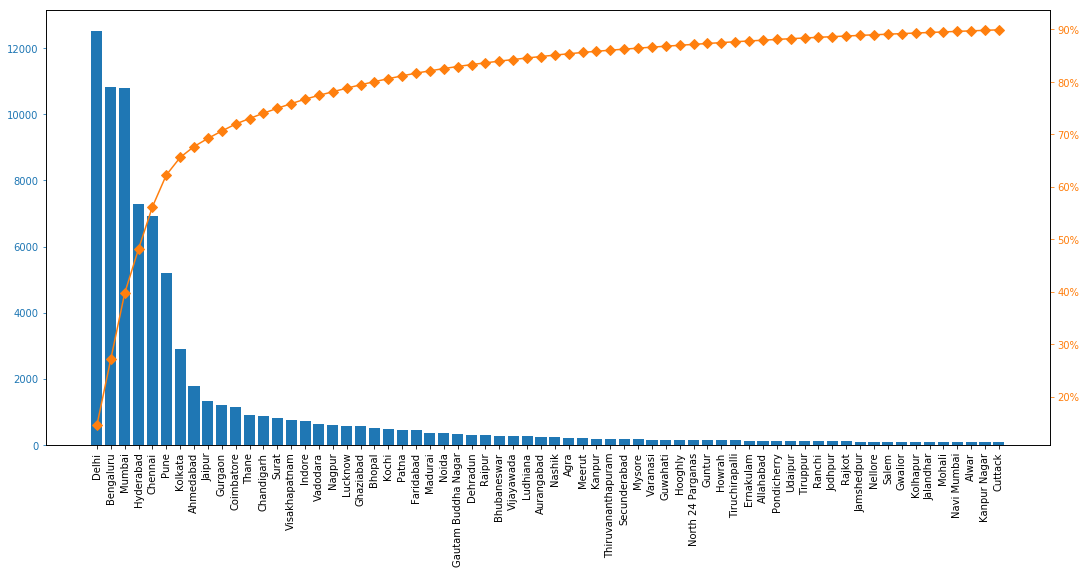

In [7]:
# wybranie tylko 60% najczęsciej występujących miast, reszcie przypisanie "Other"
df.loc[(~df['City'].isin (
           wykres_pareto('City', df, 0.9))
           ), 'City'] = 'Other'
# kodowanie zmiennych 0-1
City_dummies = pd.get_dummies(df['City'], prefix='City', dummy_na=True)

#### Zmienna Monthly_Income

C:\Users\b0623364\Projects\Anaconda\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


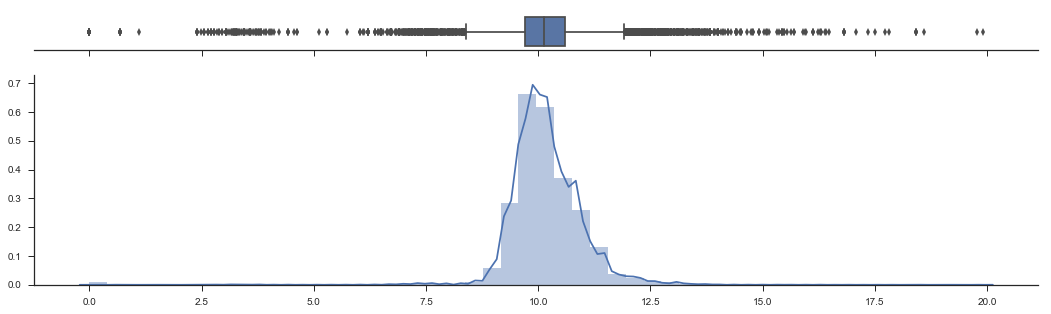

In [8]:
# przekształcenie zmiennej w transforamcji Boxa-Coxa
Monthly_Income = stats.boxcox(df['Monthly_Income']+1, 0)

# efekt przekształceń (z pominięciem wartości zerowych)
wykres_analiza(Monthly_Income, 18, 5)

#### Zmienna DOB

In [9]:
# zamiana typu zmiennych zawierających datę na typ czasowy
DOB = pd.to_datetime(df['DOB'], format='%d-%b-%y')
# poprawa parsowania dat bez wieku
DOB.loc[(DOB >= '2000-01-01') & (DOB <= '2068-12-31')] = DOB - pd.offsets.DateOffset(years=100)

#### Zmienna  Lead_Creation_Date

In [10]:
# zamiana typu zmiennych zawierających datę na typ czasowy
Lead_Creation_Date = pd.to_datetime(df['Lead_Creation_Date'], format='%d-%b-%y')

#### Zmienna Loan_Amount_Applied

C:\Users\b0623364\Projects\Anaconda\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


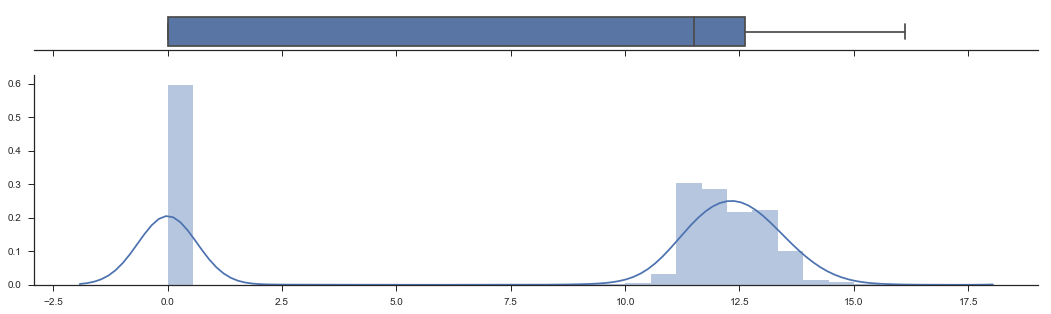

In [11]:
# zastąpienie brakujących danych
imp = Imputer(missing_values= "NaN", strategy="mean")
imp.fit(df[["Loan_Amount_Applied"]])
Loan_Amount_Applied = imp.transform(df[["Loan_Amount_Applied"]]).ravel()
df["Loan_Amount_Applied"] = Loan_Amount_Applied

# przekształcenie zmiennej w transforamcji Boxa-Coxa
Loan_Amount_Applied = stats.boxcox(Loan_Amount_Applied + 1, 0)

# efekt przekształceń (z pominięciem wartości zerowych)
wykres_analiza(Loan_Amount_Applied, 18, 5)

#### Zmienna Loan_Tenure_Applied

C:\Users\b0623364\Projects\Anaconda\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


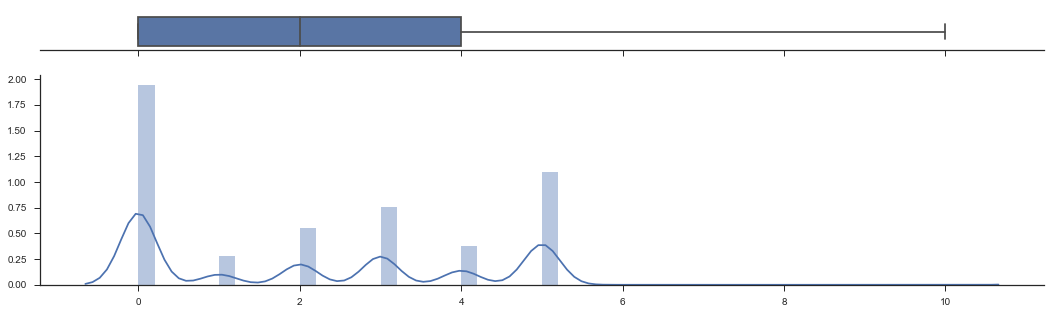

In [12]:
# zastąpienie brakujących danych
imp = Imputer(missing_values= "NaN", strategy="mean")
imp.fit(df[["Loan_Tenure_Applied"]])
Loan_Tenure_Applied = imp.transform(df[["Loan_Tenure_Applied"]]).ravel()
df["Loan_Tenure_Applied"] = Loan_Tenure_Applied

# efekt przekształceń (z pominięciem wartości zerowych)
wykres_analiza(Loan_Tenure_Applied, 18, 5)

In [13]:
Rata = df['Loan_Amount_Applied']/df['Loan_Tenure_Applied']/12
Rata[(df['Loan_Amount_Applied'].isna())] = 0
Rata[(df['Loan_Tenure_Applied'].isna())] = 0
Rata[(df['Loan_Amount_Applied'] == 0)] = 0
Rata[(df['Loan_Tenure_Applied'] == 0)] = 0

#### Zmienna Existing_EMI

C:\Users\b0623364\Projects\Anaconda\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


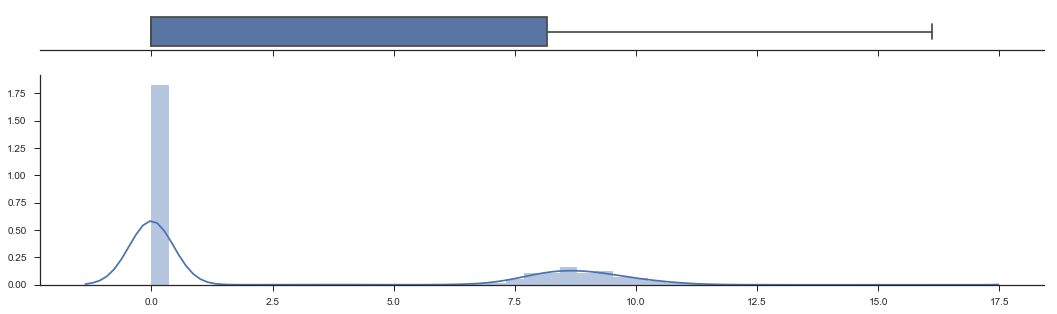

In [14]:
# zastąpienie brakujących danych
imp = Imputer(missing_values= "NaN", strategy="mean")
imp.fit(df[["Existing_EMI"]])
Existing_EMI = imp.transform(df[["Existing_EMI"]]).ravel()

Zdolnosc = df['Monthly_Income'] - Existing_EMI
Zdolnosc[Zdolnosc < 0] = 0

# przekształcenie zmiennej w transforamcji Boxa-Coxa
Existing_EMI = stats.boxcox(Existing_EMI + 1, 0)

# efekt przekształceń (z pominięciem wartości zerowych)
wykres_analiza(Existing_EMI, 18, 5)

#### Zmienna Employer_Name

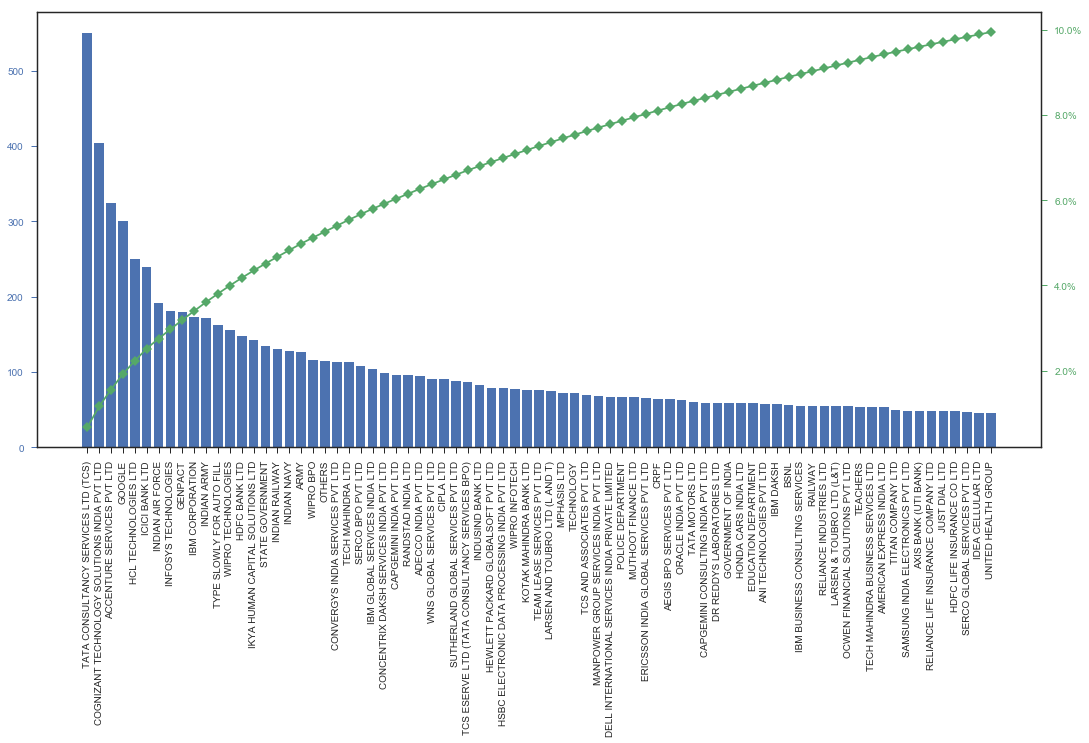

In [15]:
# potraktowanie wpisu nazwy pracodawcy = "0" jako braku danych
df.loc[(df['Employer_Name'] == '0'), 'Employer_Name'] = np.nan

# wybranie tylko 4% najczęsciej występujących miast, reszcie przypisanie "Other"
df.loc[(~df['Employer_Name'].isin (
           wykres_pareto('Employer_Name', df, 0.1))
           ), 'Employer_Name'] = 'Other'
# kodowanie zmiennych 0-1
Employer_Name_dummies = pd.get_dummies(df['Employer_Name'], prefix='Employer_Name', dummy_na=True)

#### Zmienna Salary_Account

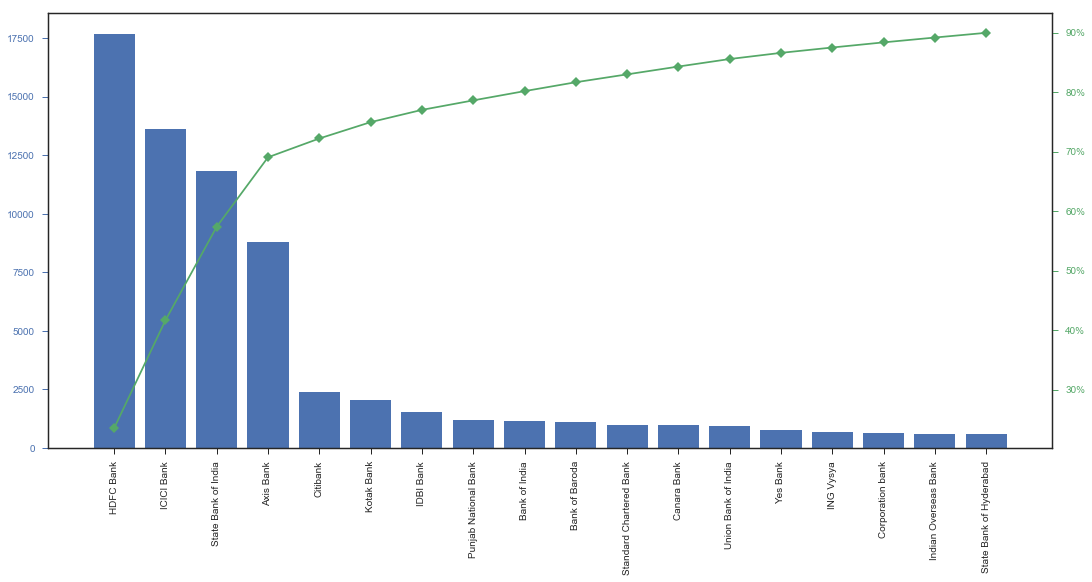

In [16]:
# wybranie tylko 80% najczęsciej występujących miast, reszcie przypisanie "Other"
df.loc[(~df['Salary_Account'].isin (
           wykres_pareto('Salary_Account', df, 0.9))
           ), 'Salary_Account'] = 'Other'
# kodowanie zmiennych 0-1
Salary_Account_dummies = pd.get_dummies(df['Salary_Account'], prefix='Salary_Account', dummy_na=True)

#### Zmienna Mobile_Verified

In [17]:
# kodowanie zmiennych 0-1
Mobile_Verified_dummies = pd.get_dummies(df['Mobile_Verified'], prefix='Mobile_Verified')

#### Zmienna Var5

C:\Users\b0623364\Projects\Anaconda\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


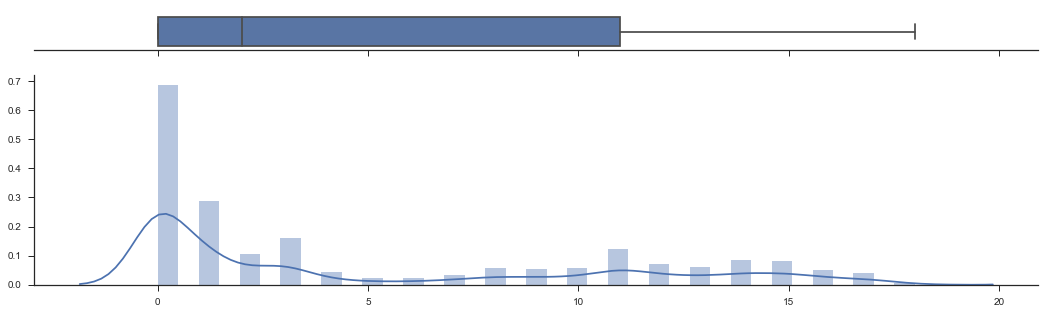

In [18]:
# przypisanie zmiennej
Var5 = df['Var5']

# efekt przekształceń (z pominięciem wartości zerowych)
wykres_analiza(Var5, 18, 5)

#### Zmienna Var1

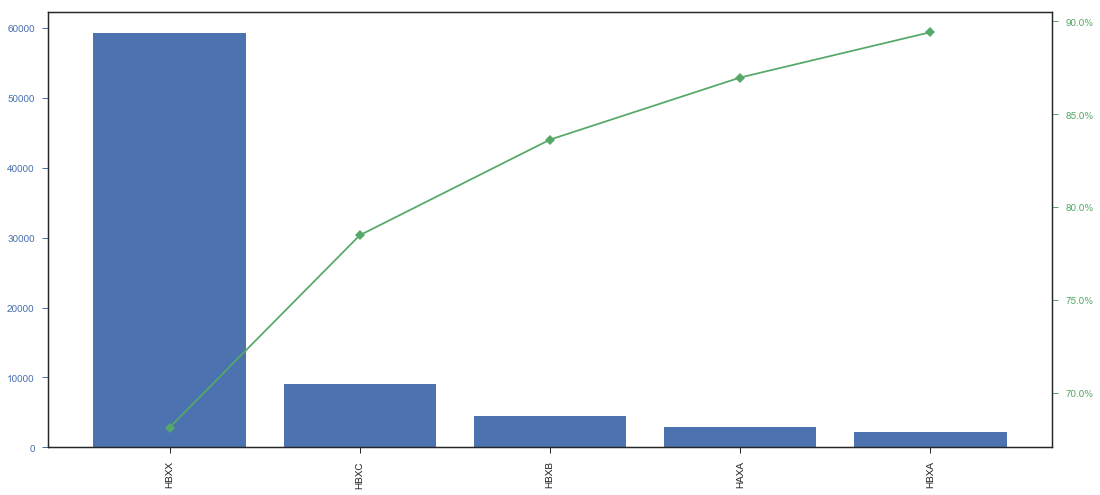

In [19]:
# wybranie tylko 90% najczęsciej występujących wartości, reszcie przypisanie "Other"
df.loc[(~df['Var1'].isin (
           wykres_pareto('Var1', df, 0.9))
           ), 'Var1'] = 'Other'
# kodowanie zmiennych 0-1
Var1_dummies = pd.get_dummies(df['Var1'], prefix='Var1', dummy_na=False)

#### Zmienna Loan_Amount_Submitted 

C:\Users\b0623364\Projects\Anaconda\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


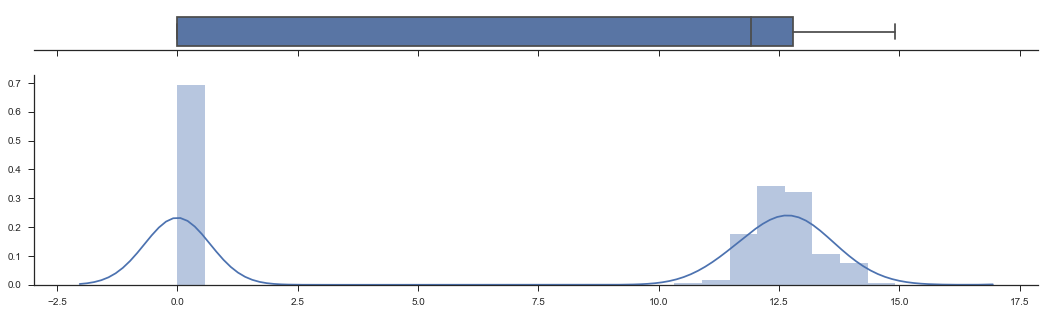

In [20]:
# uzupełnienie braków na podstawie zmiennej Loan_Amount_Applied
df.loc[(df['Loan_Amount_Submitted'].isna()), 'Loan_Amount_Submitted'] = 0 #df['Loan_Amount_Applied']

# przypisanie zmiennej
Loan_Amount_Submitted = df['Loan_Amount_Submitted']

#Loan_Amount_Submitted[df['Loan_Amount_Submitted'].isna()] = 0

# przekształcenie zmiennej w transforamcji Boxa-Coxa
Loan_Amount_Submitted = stats.boxcox(Loan_Amount_Submitted + 1, 0)

# efekt przekształceń
wykres_analiza(Loan_Amount_Submitted, 18, 5)

#### Zmienna Loan_Tenure_Submitted 

C:\Users\b0623364\Projects\Anaconda\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


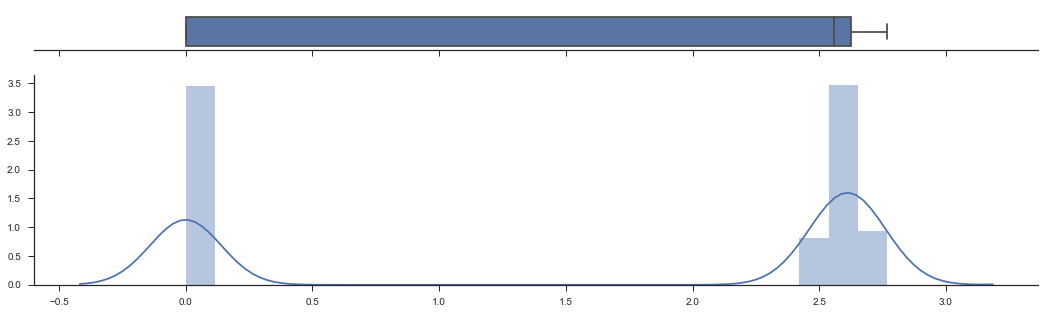

In [21]:
# uzupełnienie braków na podstawie zmiennej Loan_Amount_Applied
df.loc[(df['Loan_Tenure_Submitted'].isna()), 'Loan_Tenure_Submitted'] = 0 #df['Loan_Tenure_Applied']
#Loan_Tenure_Submitted[df['Loan_Tenure_Submitted'].isna()] = 0

# przypisanie zmiennej
Loan_Tenure_Submitted = df['Loan_Tenure_Submitted']

# przekształcenie zmiennej w transforamcji Boxa-Coxa
Loan_Tenure_Submitted = stats.boxcox(Loan_Amount_Submitted + 1, 0)

# efekt przekształceń
wykres_analiza(Loan_Tenure_Submitted, 18, 5)

#### Zmienna Interest_Rate

C:\Users\b0623364\Projects\Anaconda\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\b0623364\Projects\Anaconda\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


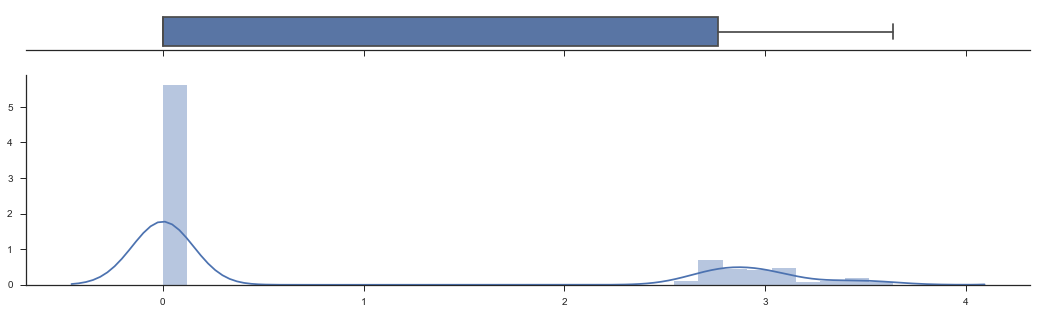

In [22]:
# przypisanie zmiennej
Interest_Rate = df['Interest_Rate']

# uzupełnienie braków na podstawie zmiennej Loan_Amount_Applied
#df.loc[(df['Interest_Rate'].isna()), 'Interest_Rate'] = df['Interest_Rate']
Interest_Rate[df['Interest_Rate'].isna()] = 0

# przekształcenie zmiennej w transforamcji Boxa-Coxa
Interest_Rate = stats.boxcox(Interest_Rate + 1, 0)

# efekt przekształceń
wykres_analiza(Interest_Rate, 18, 5)

#### Zmienna Processing_Fee

C:\Users\b0623364\Projects\Anaconda\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\b0623364\Projects\Anaconda\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


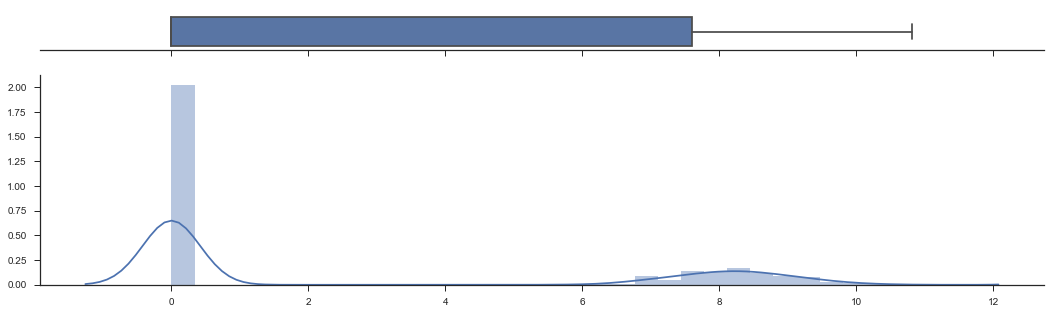

In [23]:
# przypisanie zmiennej
Processing_Fee = df['Processing_Fee']

# uzupełnienie braków na podstawie zmiennej Loan_Amount_Applied
#df.loc[(df['Processing_Fee'].isna()), 'Processing_Fee'] = df['Processing_Fee']
Processing_Fee[df['Processing_Fee'].isna()] = 0

# przekształcenie zmiennej w transforamcji Boxa-Coxa
Processing_Fee = stats.boxcox(Processing_Fee + 1, 0)

# efekt przekształceń
wykres_analiza(Processing_Fee, 18, 5)

#### Zmienna EMI_Loan_Submitted

C:\Users\b0623364\Projects\Anaconda\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\b0623364\Projects\Anaconda\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


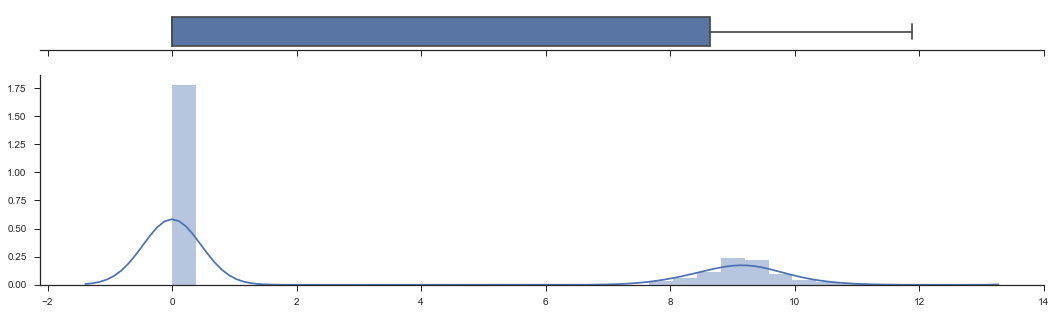

In [24]:
# przypisanie zmiennej
EMI_Loan_Submitted = df['EMI_Loan_Submitted']

# uzupełnienie braków na podstawie zmiennej EMI_Loan_Submitted
#df.loc[(df['EMI_Loan_Submitted'].isna()), 'EMI_Loan_Submitted'] = df['EMI_Loan_Submitted']
EMI_Loan_Submitted[df['EMI_Loan_Submitted'].isna()] = 0

# przekształcenie zmiennej w transforamcji Boxa-Coxa
EMI_Loan_Submitted = stats.boxcox(EMI_Loan_Submitted + 1, 0)

# efekt przekształceń
wykres_analiza(EMI_Loan_Submitted, 18, 5)

#### Zmienna Filled_Form

In [25]:
# kodowanie zmiennych 0-1
Filled_Form_dummies = pd.get_dummies(df['Filled_Form'], prefix='Filled_Form')

#### Zmienna Device_Type

In [26]:
# kodowanie zmiennych 0-1
Device_Type_dummies = pd.get_dummies(df['Device_Type'], prefix='Device_Type')

#### Zmienna Var2

In [27]:
# kodowanie zmiennych 0-1
Var2_dummies = pd.get_dummies(df['Var2'], prefix='Var2')

#### Zmienna Source

In [28]:
# kodowanie zmiennych 0-1
Source_dummies = pd.get_dummies(df['Source'], prefix='Source')

#### zmienna Var4 

In [29]:
# kodowanie zmiennych 0-1
Var4_dummies = pd.get_dummies(df['Var4'], prefix='Var4')

#### zmienna Age

C:\Users\b0623364\Projects\Anaconda\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


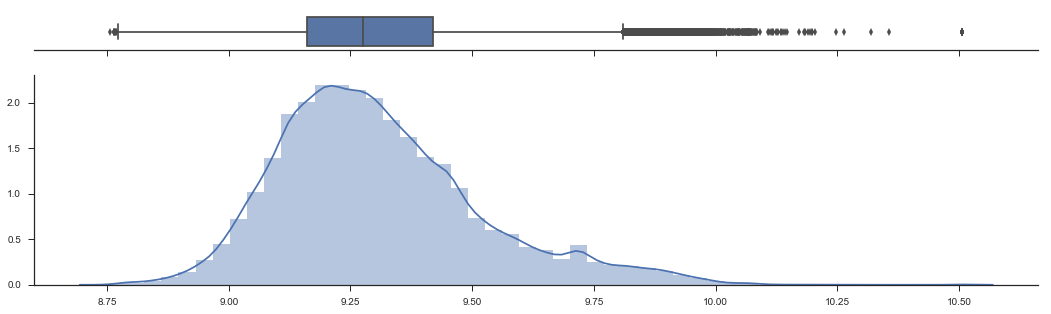

In [30]:
# obliczenie wieku klienta w momencie złożenia wniosku (w dniach)
Age = (((Lead_Creation_Date - DOB)/ np.timedelta64(1, 'D')).astype(int))

# przekształcenie zmiennej w transforamcji Boxa-Coxa
Age = stats.boxcox(Age + 1, 0)

wykres_analiza(Age, 18, 5)

### Złożenie przekształceń i pominięcie części zmiennych

In [31]:
df1 = pd.concat([
    df['Disbursed'],
    Gender_dummies,
    City_dummies,
    Employer_Name_dummies,
    Salary_Account_dummies,
    Mobile_Verified_dummies,
    Var5,
    Var1_dummies,
    Filled_Form_dummies,
    Device_Type_dummies,
    Var2_dummies,
    Source_dummies,
    Var4_dummies
    ], axis=1)

df1['Monthly_Income'] = Monthly_Income
df1['Loan_Amount_Applied'] = Loan_Amount_Applied
df1['Loan_Tenure_Applied'] = Loan_Tenure_Applied
df1['Existing_EMI'] = Existing_EMI
df1['Loan_Amount_Submitted'] = Loan_Amount_Submitted
df1['Loan_Tenure_Submitted'] = Loan_Tenure_Submitted
df1['Interest_Rate'] = Interest_Rate
df1['Processing_Fee'] = Processing_Fee
df1['EMI_Loan_Submitted'] = EMI_Loan_Submitted
df1['Rata'] = Rata
df1['Zdolnosc'] = Zdolnosc

### Podgląd danych po przekształceniach

In [32]:
# opis zmiennych

header = ['#Unik_wart','Typ', 'Puste', 'Zera', 'Minimum']
slownik = {column: [
    len(pd.value_counts(df1[column])), 
    df1[column].dtype, 
    df1[column].isna().sum(),
    (df1[column]==0).sum(),
    np.min(df1[column]) 
    ] for column in df1.columns}
kolumny = pd.DataFrame.from_dict(slownik, columns = header, orient='index')

kolumny

,#Unik_wart,Typ,Puste,Zera,Minimum
Disbursed,2,int64,0,85747,0.0
Gender_Female,2,uint8,0,49848,0.0
Gender_Male,2,uint8,0,37172,0.0
City_Agra,2,uint8,0,86801,0.0
City_Ahmedabad,2,uint8,0,85232,0.0
City_Allahabad,2,uint8,0,86894,0.0
City_Alwar,2,uint8,0,86934,0.0
City_Aurangabad,2,uint8,0,86783,0.0
City_Bengaluru,2,uint8,0,76196,0.0
City_Bhopal,2,uint8,0,86507,0.0


### Poszukiwanie najlepszego modelu

In [33]:
X = df1.drop(columns=["Disbursed"])
y = df1.Disbursed
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [56]:
# etykiety porównywanych modeli
names = np.array(["Naiwny Bayes", "Drzewo decyzyjne", "Regresja logistyczna", "SVM",
                 "BaggingClassifier_tree", "BaggingClassifier_bayes", "RandomForest", "XGBoost"])

# definicja pipeline
models = [[("model", MultinomialNB())],
         [("model", DecisionTreeClassifier())],
         [("scaler", StandardScaler()), ("model", LogisticRegression())],
         [("scaler", StandardScaler()), ("model", SVC())],
         [("model", BaggingClassifier(base_estimator = DecisionTreeClassifier()))],
         [("model", BaggingClassifier(base_estimator = MultinomialNB()))],
         [("scaler", StandardScaler()), ("model", RandomForestClassifier())],
         [("model", xgb.XGBClassifier(
                booster = 'gbtree', 
                objective = 'binary:logistic', 
                max_depth = 11, 
                eval_metric = 'auc',
                eta = 0.01, 
                silent = 1, 
                nthread = 4,
                colsample_bytree = 0.99, 
                scale_pos_weight = 1,
                min_child_weight = 2, 
                max_delta_step = 3,
                n_jobs = 3,
                subsample = 0.99
         ))]
         ]

# warianty testowanych parametrów
param_grids = [{"model__alpha": [0.01, 1, 1000], "model__fit_prior": [False, True]},
               {"model__criterion": ["gini", "entropy"], "model__min_samples_split": [2, 10, 20], "model__max_depth": [None, 2, 10, 100, 200, 1000]}, 
               {"model__penalty": ["l1", "l2"], "model__C": [0.001, 1, 100]},
              [{"model__kernel": ["rbf"], "model__gamma": [0.1, 1, 10]},
              {"model__kernel": ["poly"], "model__degree": [3, 4, 5]}],
               {"model__n_estimators" : [10, 100, 1000], "model__max_features": [0.1, 0.5, 0.8, 1.0]},
               {"model__n_estimators" : [10, 100, 1000], "model__max_features": [0.5, 0.8, 1.0]},
               {"model__n_estimators" : [10, 100, 1000], "model__min_samples_leaf" : [2, 10, 20, 50]},
               {"model__n_estimators" : [10, 100, 1000]}
              ]

# służy do włączania/wyłączania odpowiedniego modelu z obliczeń 
uses = np.array([False, False, False, False, False, False, False, True])

# testowanie poprawności definicji modeli
if len(names) != len(models) or len(models) != len(param_grids) or len(param_grids) != len(uses):
    print(f"len(names): {len(names)}")
    print(f"len(models): {len(models)}")
    print(f"len(param_grids): {len(param_grids)}")
    print(f"len(uses): {len(uses)}")
    raise ValueError("Listy nie mają tej samej długości!")

# uczenie/estymacja parametrów rozważanych modeli i wybór najlepszego w danej klasie    
best_models = []

for use, name, pipe, params in zip(uses, names, models, param_grids):
    if not use:
        continue
    print(f"Estymacja modelu: {name}")
    pipeline = Pipeline(pipe)
    gs = GridSearchCV(estimator=pipeline, param_grid=params, n_jobs=3, scoring = 'roc_auc', cv=5)
    gs.fit(X_train, y_train)
    for mean, std, param, fit_time, score_time in zip(gs.cv_results_["mean_test_score"],
                                gs.cv_results_["std_test_score"],
                                gs.cv_results_["params"],
                                gs.cv_results_["mean_fit_time"],
                                gs.cv_results_["mean_score_time"]):
        print(f"{param}:\n mean: {np.round(mean, 4)}, std: {np.round(std,4)},\n fit_time: {np.round(fit_time, 4)}, score_time: {np.round(score_time,4)}\n")
    best_models.append(gs.best_estimator_)

best_models = np.array(best_models)

Estymacja modelu: XGBoost
{'model__n_estimators': 10}:
 mean: 0.8216, std: 0.0141,
 fit_time: 12.6023, score_time: 0.4188

{'model__n_estimators': 100}:
 mean: 0.8489, std: 0.0123,
 fit_time: 160.5324, score_time: 0.5031

{'model__n_estimators': 1000}:
 mean: 0.8033, std: 0.0131,
 fit_time: 1363.9194, score_time: 0.9438



### Porównanie najlepszych modeli

In [57]:
header = ['accuracy_score', 'f1_score', 'recall_score', 'recall_score:1', 'roc_auc_score', 'ile1']
slownik = {name: [
    np.round(accuracy_score(best_model.predict(X_test), y_test), 5),
    np.round(f1_score(best_model.predict(X_test), y_test, average='weighted'), 5),
    np.round(recall_score(best_model.predict(X_test), y_test, average='weighted'), 5),
    np.round(recall_score(best_model.predict(X_test), y_test, average=None)[1], 5),
    np.round(roc_auc_score(best_model.predict(X_test), y_test), 5) if best_model.predict(X_test).sum() > 0 else 0,
    best_model.predict(X_test).sum()
    
    ] for name, best_model in zip(names[uses], best_models)}

wyniki = pd.DataFrame.from_dict(slownik, columns = header, orient='index')
wyniki

C:\Users\b0623364\Projects\Anaconda\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\b0623364\Projects\Anaconda\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\b0623364\Projects\Anaconda\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\b0623364\Projects\Anaconda\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empt

,accuracy_score,f1_score,recall_score,recall_score:1,roc_auc_score,ile1
XGBoost,0.98475,0.99217,0.98475,0.0,0.49245,4


In [38]:
print(best_models[0].predict(X_test).sum())
print(y_test.sum())

14041
394


In [39]:
model = best_models[0].named_steps['model']

print(model.feature_importances_)
# plot
plt.bar(range(len(model.feature_importances_)), model.feature_importances_)
plt.show()


AttributeError: 'MultinomialNB' object has no attribute 'feature_importances_'

In [40]:
from xgboost import plot_importance



ax = plot_importance(model)
fig = ax.figure
fig.set_size_inches(10, 30)

ValueError: tree must be Booster, XGBModel or dict instance